In [1]:
import os
from os.path import join, exists
from functools import partial
from glob import glob
import torch
from matplotlib import pyplot as plt, colors, transforms
from scipy.io import loadmat
from sklearn.metrics import confusion_matrix
import numpy as np
import pandas as pd
import mne
from mne.datasets import eegbci
from mne.io import read_raw_edf
from mne.viz import plot_topomap, plot_alignment
from mayavi import mlab
import warnings

warnings.filterwarnings("ignore", category=DeprecationWarning)
mlab.init_notebook("x3d", 800, 600)

plot_topomap = partial(plot_topomap, contours=False, show=False, sphere=[0,0,0,0.4])

Notebook initialized with x3d backend.


In [15]:
max_models = 3 # maximum number of models to load for one frequency range (-1 to load all models)
min_confidence = 0.75 # minimum confidence to keep a prediction (0: no confidence, 1: full confidence)
model_dir = "../lightning_logs/baseline_models/" # path to the log directory of the model checkpoints

In [16]:
paths = glob(join(model_dir, "**", "attention.pt"), recursive=True)
assert len(paths) > 0, "didn't find any attention weights"

if len(paths) == 1:
    print(f"loading data for a single model")
    # load extracted attention weights and metadata
    (attn, confidence, pred, labels, subjects, hparams,
     condition_mapping, subject_mapping) = torch.load(paths[0])
    all_model_ids = torch.zeros(len(attn), dtype=torch.int)
    model_name_mapping = {0: paths[0].split(os.sep)[-2]}
else:
    # load extracted attention weights and metadata from a range of models and combine them
    print(f"loading data for {len(paths)} models")

    attn, confidence, pred, labels, subjects, all_model_ids = [], [], [], [], [], [], []
    model_name_mapping = dict()
    for i, path in enumerate(paths):
        if (max_models > 0 and
            not path.split("/")[-2].startswith("version_") and
            int(path.split("/")[-2][-1]) > max_models):
            print(f"skipping {path} due to count limit")
            continue
        
        (a, c, p, l, su,
         hparams, condition_mapping, subject_mapping) = torch.load(path)
        attn.append(a)
        confidence.append(c)
        pred.append(p)
        labels.append(l)
        subjects.append(su)
        all_model_ids.append(torch.tensor([i] * len(a)))
        model_name_mapping[i] = path.split(os.sep)[-2]

    attn = torch.cat(attn)
    confidence = torch.cat(confidence)
    pred = torch.cat(pred)
    labels = torch.cat(labels)
    subjects = torch.cat(subjects)
    all_model_ids = torch.cat(all_model_ids)

loading data for 25 models
skipping ../lightning_logs/baseline_models/theta4/attention.pt due to count limit
skipping ../lightning_logs/baseline_models/delta4/attention.pt due to count limit
skipping ../lightning_logs/baseline_models/combined4/attention.pt due to count limit
skipping ../lightning_logs/baseline_models/alpha4/attention.pt due to count limit
skipping ../lightning_logs/baseline_models/beta4/attention.pt due to count limit


In [17]:
# create a new list of model ids where models with the same name but different postfix digit are combined
mapping = {}
for idx, name in model_name_mapping.items():
    if name[-1].isdigit():
        name = name[:-1]
        if name in mapping:
            mapping[name].append(idx)
        else:
            mapping[name] = [idx]

idx_mapping = {}
for i, (name, idxs) in enumerate(mapping.items()):
    for idx in idxs:
        idx_mapping[idx] = i

if len(idx_mapping) == len(mapping):
    all_model_ids_comb = all_model_ids
    model_name_mapping_comb = model_name_mapping
else:
    all_model_ids_comb = torch.zeros_like(all_model_ids)
    model_name_mapping_comb = {}
    for model_id in np.unique(all_model_ids):
        mask = all_model_ids == model_id
        new_id = idx_mapping[model_id]
        all_model_ids_comb[mask] = new_id
        model_name_mapping_comb[new_id] = list(mapping.keys())[new_id]

In [18]:
# mask out attention weights of incorrect low-confidence predictions
confidence_mask = confidence >= min_confidence
correct_mask = pred == labels
attn_mask = confidence_mask & correct_mask
attn = attn[attn_mask]
model_ids = all_model_ids[attn_mask]
model_ids_comb = all_model_ids_comb[attn_mask]

# create a mask where condition 0 is true and condition 1 is false
condition_masks = [labels[attn_mask] == i for i in labels.unique()]

print(f"loaded attention weights extracted from {len(subjects.unique())} subjects")

for name, mask in zip(condition_mapping, condition_masks):
    num_true = mask.sum().item()
    print(f"got {num_true} {name} attention maps")

print(f"validation accuracy: {correct_mask.float().mean().item():.2%}")

loaded attention weights extracted from 105 subjects and 1 stages
got 4212 eyes-open attention maps
got 4182 eyes-closed attention maps
validation accuracy: 74.62%


In [19]:
matrix = confusion_matrix(labels, pred, labels=range(len(labels.unique())), normalize="pred")

fmt = lambda x: f"{x:.2%}"
pd.DataFrame(data=matrix, index=condition_mapping, columns=condition_mapping).applymap(fmt)

,eyes-open,eyes-closed
eyes-open,72.94%,23.44%
eyes-closed,27.06%,76.56%


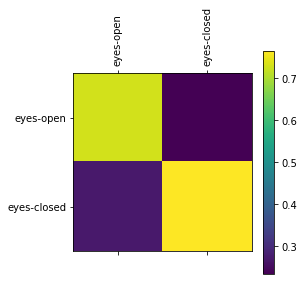

In [20]:
plt.matshow(matrix)
plt.colorbar()
plt.xticks(range(len(condition_mapping)), condition_mapping, rotation=90)
plt.yticks(range(len(condition_mapping)), condition_mapping)
plt.show()

In [21]:
def accuracy(pred, labels):
    return (pred == labels).float().mean().item()

print("individual models:")
for i in model_ids.unique().numpy():
    mask = all_model_ids == i
    acc = accuracy(pred[mask], labels[mask])
    print(f"model {model_name_mapping[i]}: {acc:.2%}")

print("\ngrouped models:")
for i in model_ids_comb.unique().numpy():
    mask = all_model_ids_comb == i
    acc = accuracy(pred[mask], labels[mask])
    print(f"model {model_name_mapping_comb[i]}: {acc:.2%}")

individual models:
model combined1: 76.46%
model delta1: 71.77%
model delta2: 69.06%
model theta0: 71.04%
model alpha3: 83.23%
model combined2: 84.17%
model theta1: 67.81%
model beta0: 71.67%
model theta3: 71.04%
model beta3: 75.73%
model combined3: 76.46%
model beta1: 78.23%
model alpha0: 78.75%
model beta2: 66.77%
model alpha2: 71.88%
model combined0: 80.83%
model theta2: 71.88%
model delta3: 79.37%
model delta0: 76.67%
model alpha1: 69.58%

grouped models:
model combined: 79.48%
model delta: 74.22%
model theta: 70.44%
model alpha: 75.86%
model beta: 73.10%


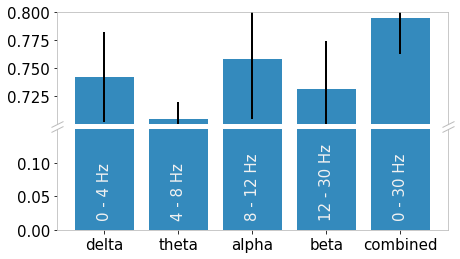

In [22]:
fontsize = 15
order = [1, 2, 3, 4, 0]
freqs = ["0 - 4 Hz", "4 - 8 Hz", "8 - 12 Hz", "12 - 30 Hz", "0 - 30 Hz"]

names, accuracies, stds = [], [], []
for i in model_ids_comb.unique().numpy()[order]:
    mask = all_model_ids_comb == i
    names.append(model_name_mapping_comb[i])
    accuracies.append(accuracy(pred[mask], labels[mask]))

    individual = [accuracy(pred[all_model_ids == idx], labels[all_model_ids == idx]) for idx in mapping[names[-1]]]
    stds.append(np.std(individual))

if not exists("../figures"):
    os.makedirs("../figures")
    
plt.style.use("bmh")
plt.rcParams.update({"xtick.direction": "out", "ytick.direction": "out", "axes.facecolor": "1"})

fig, (ax1, ax2) = plt.subplots(nrows=2, sharex=True, figsize=(7, 4), gridspec_kw=dict(height_ratios=[1, 0.9]))
plt.subplots_adjust(hspace=0.05)

ax1.spines.bottom.set_visible(False)
ax2.spines.top.set_visible(False)
ax1.tick_params(axis="x", which="both", bottom=False, top=False, labelbottom=False)
ax2.xaxis.tick_bottom()

ax1.set_ylim(0.7, 0.8)
ax2.set_ylim(0, 0.15)

ax1.bar(range(len(accuracies)), accuracies, yerr=stds)
ax2.bar(range(len(accuracies)), accuracies)
ax2.set_xticks(range(len(accuracies)), names, fontsize=fontsize)

d = .5
color = ax1.spines["left"].get_edgecolor()
kwargs = dict(marker=[(-1, -d), (1, d)], markersize=12,
              linestyle="none", color=color, mec=color, mew=1, clip_on=False)
ax1.plot([0, 1], [0, 0], transform=ax1.transAxes, **kwargs)
ax2.plot([0, 1], [1, 1], transform=ax2.transAxes, **kwargs)

ax1.set_yticks(ax1.get_yticks()[1:])
ax2.set_yticks(ax2.get_yticks()[:-1])
ax1.tick_params(axis="y", labelsize=fontsize)
ax2.tick_params(axis="y", labelsize=fontsize)

for i in range(len(accuracies)):
    ax2.text(i, 0.015, freqs[i], rotation=90, va="bottom", ha="center", fontsize=fontsize, color="0.95")

ax1.grid()
ax2.grid()

plt.savefig("../figures/accuracies.pdf", dpi=300, bbox_inches="tight")
plt.show()

# load metadata

In [23]:
if hparams.num_channels == 20:
    ###############################################
    ################# 20 channels #################
    ###############################################
    # set the montage type
    montage_type = "standard_1020"
    # define channel names
    channels = ['Fp1', 'Fp2', 'F3', 'F4', 'F7', 'F8', 'C3', 'C4', 'P3', 'P4',
                'O1', 'O2', 'T3', 'T4', 'T5', 'T6', 'Fz', 'Cz', 'Pz', 'Oz']
    # load EEG sensor positions to be used in the topomaps
    sensor_pos = loadmat(join("../data", 'Coo_caf'))['Cor'].T
    sensor_pos = np.array([sensor_pos[1], sensor_pos[0]]).T
elif hparams.num_channels == 64:
    ###############################################
    ################# 64 channels #################
    ###############################################
    # set the montage type
    montage_type = "standard_1005"
    # define channel names
    def standardize(ch_names):
        names = []
        for name in ch_names:
            std_name = name.strip(".")
            std_name = std_name.upper()
            if std_name.endswith("Z"):
                std_name = std_name[:-1] + "z"
            if std_name.startswith("FP"):
                std_name = "Fp" + std_name[2:]
            names.append(std_name)
        return names

    channels = standardize(read_raw_edf(eegbci.load_data(1, 1)[0]).ch_names)
    print("\nreference channels:", dict(T9=channels.index("T9"),
                                        T10=channels.index("T10"),
                                        Iz=channels.index("Iz")))
    # load EEG sensor positions to be used in the topomaps
    layout = mne.channels.read_layout("EEG1005")
    sensor_pos = np.empty((hparams.num_channels, 2))
    for i, name in enumerate(channels):
        idx = layout.names.index(name)
        sensor_pos[i] = layout.pos[idx][:2]
    sensor_pos -= sensor_pos.mean(axis=0)

Extracting EDF parameters from /home/philipp/mne_data/MNE-eegbci-data/files/eegmmidb/1.0.0/S001/S001R01.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...

reference channels: {'T9': 42, 'T10': 43, 'Iz': 63}


In [24]:
# remove channels that are listed in the model's ignore_channel list
num_channels = hparams.num_channels
if len(hparams.ignore_channels) > 0:
    print("dropping channels", ", ".join(channels[i] for i in hparams.ignore_channels))
    channels = [ch for i, ch in enumerate(channels) if i not in hparams.ignore_channels]
    num_channels = len(channels)
    sensor_pos = np.array([p for i, p in enumerate(sensor_pos) if i not in hparams.ignore_channels])

dropping channels T9, T10, Iz


# plotting functions

In [ ]:
def colorbar(vmin, vmax, cmap, ax=None, cax=None, orientation="vertical", fontsize=None):
    norm = colors.Normalize(vmin=vmin,vmax=vmax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, ax=ax, cax=cax, orientation=orientation)
    if fontsize is not None:
        cbar.ax.tick_params(labelsize=fontsize)

In [ ]:
def temporal_topomaps(attn_weights, masks, title="", cmap="Reds"):
    axes = plt.subplots(len(masks), hparams.num_tokens + 1, figsize=(15, 5),
                        gridspec_kw=dict(width_ratios=[1] * hparams.num_tokens + [0.1]))[1]
    plt.suptitle(title, fontsize=20, y=1.1)

    for i, mask in enumerate(masks):
        curr = attn_weights[mask].mean(dim=0)
        vmin, vmax = curr.min(), curr.max()
        axes[i,0].set_ylabel(condition_mapping[i], fontsize=15)
        for j in range(curr.size(0)):
            plot_topomap(curr[j], sensor_pos, axes=axes[i,j], vmin=vmin, vmax=vmax, cmap=cmap)
            axes[i,j].set_title(f"$t_{j}$", fontsize=15)
        colorbar(vmin, vmax, cmap, cax=axes[i,-1])
    plt.show()

In [ ]:
def temporal_avg_topomaps(attn_weights, masks, title="", cmap="Reds"):
    axes = plt.subplots(ncols=len(masks), figsize=(13, 4))[1]
    plt.suptitle(title, fontsize=20, y=1.15)

    for i, mask in enumerate(masks):
        curr = attn_weights[mask].mean(dim=(0, 1))
        
        axes[i].set_title(condition_mapping[i], fontsize=15)
        vmin, vmax = curr.min(), curr.max()
        plot_topomap(curr, sensor_pos, axes=axes[i], vmin=vmin, vmax=vmax, cmap=cmap)
        colorbar(vmin, vmax, cmap, axes[i])
    plt.show()

In [ ]:
def diff_topomap(attn_weights, masks, mask_indices):
    mask0 = masks[mask_indices[0]]
    mask1 = masks[mask_indices[1]]
    
    diff = attn_weights[mask0].mean(dim=(0, 1)) - attn_weights[mask1].mean(dim=(0, 1))

    vmin, vmax = diff.min(), diff.max()
    absmax = max(abs(vmin), abs(vmax))

    plt.title(f"{condition_mapping[mask_indices[0]]} - {condition_mapping[mask_indices[1]]}", fontsize=15)
    plot_topomap(diff, sensor_pos, vmin=-absmax, vmax=absmax, cmap="coolwarm")
    colorbar(-absmax, absmax, "coolwarm")
    plt.show()

In [ ]:
def temporal_avg_topomaps_models(attn_weights, masks, model_ids, model_name_mapping, mask_indices,
                                 model_order=None, title="", cmap="Reds", fontsize=24, cbar_fontsize=13):
    num_models = len(model_ids.unique())
    axes_grid = plt.subplots(nrows=5, ncols=num_models + 1, figsize=(13, 8),
                             gridspec_kw=dict(width_ratios=[1] * (num_models - 1) + [0.05, 1],
                                              height_ratios=[1, 1, 0.1, 1, 0.1]))[1].T
    plt.suptitle(title, fontsize=fontsize, y=1.15)

    axes_grid[0,0].set_ylabel(condition_mapping[mask_indices[0]].replace("-", "\n"), fontsize=fontsize)
    axes_grid[0,1].set_ylabel(condition_mapping[mask_indices[1]].replace("-", "\n"), fontsize=fontsize)
    axes_grid[0,3].set_ylabel("difference\n(EO - EC)", fontsize=fontsize)
    
    for ax in axes_grid[-2]:
        ax.axis("off")
    
    for i, axes in zip(model_ids.unique().numpy(), axes_grid[[True] * (num_models - 1) + [False, True]]):
        if model_order is not None:
            i = model_order[i]
        model_mask = model_ids == i
        attn0 = attn_weights[masks[mask_indices[0]] & model_mask].mean(dim=(0, 1))
        attn0 = (attn0 - attn0.min()) / (attn0.max() - attn0.min())
        attn1 = attn_weights[masks[mask_indices[1]] & model_mask].mean(dim=(0, 1))
        attn1 = (attn1 - attn1.min()) / (attn1.max() - attn1.min())
        vmin, vmax = min(attn0.min(), attn1.min()), max(attn0.max(), attn1.max())

        axes[0].set_title(model_name_mapping[i], fontsize=fontsize)
        # condition 0
        plot_topomap(attn0, sensor_pos, axes=axes[0], vmin=vmin, vmax=vmax, cmap=cmap)
        # condition 1
        plot_topomap(attn1, sensor_pos, axes=axes[1], vmin=vmin, vmax=vmax, cmap=cmap)
        colorbar(vmin, vmax, cmap, cax=axes[2], orientation="horizontal", fontsize=cbar_fontsize)
        # difference
        diff = attn0 - attn1
        absmax = diff.abs().max()
        plot_topomap(diff, sensor_pos, axes=axes[3], vmin=-absmax, vmax=absmax, cmap="coolwarm")
        colorbar(-absmax, absmax, "coolwarm", cax=axes[4], orientation="horizontal", fontsize=cbar_fontsize)
    
    x = transforms.TransformedBbox(axes_grid[-2,0].bbox, transform=plt.gcf().transFigure.inverted())
    x = x.get_points()[:,0].mean()
    plt.plot([x, x], [0.08, 1], color=plt.rcParams["axes.edgecolor"],
             transform=plt.gcf().transFigure, clip_on=False)

# attention towards class token
This computes the attention towards the class token from the perspective of every channel and temporal token, which is an estimate of how much information each channel/token contributes towards the final prediction.

In [ ]:
class_attn = attn[:,0,1:]
class_attn /= class_attn.max(dim=1, keepdims=True).values
class_attn = class_attn.reshape(-1, hparams.num_tokens, num_channels)

In [ ]:
temporal_topomaps(class_attn, condition_masks, "attention towards class token")

In [ ]:
temporal_avg_topomaps(class_attn, condition_masks, "attention towards class token, averaged over temporal tokens")

In [ ]:
diff_topomap(class_attn, condition_masks, [0, 1])

In [ ]:
if len(model_ids.unique()) > 1:
    temporal_avg_topomaps_models(class_attn, condition_masks, model_ids_comb, model_name_mapping_comb,
                                 mask_indices=[0, 1], model_order=[1, 2, 3, 4, 0])
    plt.savefig("../figures/attn-bands.pdf", dpi=300, bbox_inches="tight")
    plt.show()
else:
    print("only got one model")

# inter-channel attention
Here we compute the total attention that each channel/token receives throughout the network, which gives an estimate of the importance for each feature while coming up with the prediction. The results seem to be almost identical to the attention towards the class token.

In [ ]:
channel_attn = attn[:,1:,1:].mean(dim=1)
channel_attn /= channel_attn.max(dim=1, keepdims=True).values
channel_attn = channel_attn.reshape(-1, hparams.num_tokens, num_channels)

In [ ]:
temporal_topomaps(channel_attn, condition_masks, "attention between channels")

In [ ]:
temporal_avg_topomaps(channel_attn, condition_masks, "attention between channels, averaged over temporal tokens")

In [ ]:
diff_topomap(channel_attn, condition_masks, [0, 1])

# 3D attention plots
These plots show three-dimensional connections of the top k attention scores averaged across temporal tokens. Line width and transparency indicates the magnitude of the attention weight (wider, more opaque lines correspond to larger attention weights). Lines are colored with a gradient from blue to red, indicating the direction of the attention weight with attention being directed from blue towards red. The directionality of attention corresponds to a flow of information.

In [25]:
# load 3D channel positions for a certain montage type
montage = mne.channels.make_standard_montage(montage_type)
info = mne.create_info(channels, 160, ch_types="eeg", verbose="error")
info.set_montage(montage);

In [26]:
def topk(val, k):
    # compute indices of top k values inside an n-dimensional tensor
    if k == -1:
        k = val.numel()
    v, i = torch.topk(val.flatten(), k)
    return np.array(np.unravel_index(i.numpy(), val.shape)).T

def quadratic_bezier(start, end, modifier, n_steps=10):
    # generate n_steps points along a quadratic bezier curve
    points = []
    for alpha in np.linspace(0, 1, n_steps):
        p1 = alpha * modifier + (1 - alpha) * start
        p2 = alpha * end + (1 - alpha) * modifier
        p = alpha * p2 + (1 - alpha) * p1
        points.append(p)
    return np.array(points)

def cubic_bezier(start, end, modifiers, n_steps=10):
    # generate n_steps points along a cubic bezier curve
    points = []
    for alpha in np.linspace(0, 1, n_steps):
        p1 = alpha * modifiers[0] + (1 - alpha) * start
        p2 = alpha * modifiers[1] + (1 - alpha) * modifiers[0]
        p3 = alpha * end + (1 - alpha) * modifiers[1]
        p4 = alpha * p2 + (1 - alpha) * p1
        p5 = alpha * p3 + (1 - alpha) * p2
        p = alpha * p5 + (1 - alpha) * p4
        points.append(p)
    return np.array(points)

def plot_3d(condition, model_mask=None, num_weights=100, n_bezier_steps=20, cmap="coolwarm"):
    # plot spheres at 3D channel locations
    fig = plot_alignment(info, dig=False, eeg=True, surfaces=[], coord_frame='head')
    mlab.figure(figure=fig, bgcolor=(1, 1, 1))
    # extract transformed channel locations
    ch_positions = fig.children[0].data.points

    if not isinstance(condition, int):
        condition = torch.tensor(condition)
        topk_idxs = topk(condition, num_weights)
        topk_attn = condition[topk_idxs.T]
        topk_attn = (topk_attn - topk_attn.min()) / (topk_attn.max() - topk_attn.min())
    else:
        if condition == -1:
            print(f"attention weights for all classes")
        else:
            print(f"attention weights for class \"{condition_mapping[condition]}\"")
        
        if condition >= 0:
            mask = condition_masks[condition]
        elif condition == -1:
            mask = torch.ones_like(condition_masks[0], dtype=torch.bool)
        if model_mask is not None:
            mask = mask & model_mask

        # average temporal tokens to get an n_channels x n_channels attention matrix
        attn_mat = attn[:,1:,1:].reshape(-1, num_channels, hparams.num_tokens,
                                         hparams.num_tokens, num_channels)
        attn_mat = attn_mat.mean(dim=-2).mean(dim=2)
        
        # extract indices of top k attention weights and normalize to [0, 1]
        topk_idxs = topk(attn_mat[mask].mean(dim=0), num_weights)
        
        topk_attn = attn_mat[mask].mean(dim=0)[topk_idxs.T]
        topk_attn = (topk_attn - topk_attn.min()) / (topk_attn.max() - topk_attn.min())

    # create a mapping from channel names to transformed 3D locations
    info_channels = [channel["ch_name"] for channel in info["chs"] if channel["ch_name"] in channels]
    pos_mapping = {name: ch_positions[info_channels.index(name)] for name in channels}
    positions_arr = np.array(list(pos_mapping.values()))
    
    # iterate over top k attention weights
    for (i, j), attn_strength in zip(topk_idxs, topk_attn):
        # start and end location of the line
        from_pos = np.array(pos_mapping[channels[i]])
        to_pos = np.array(pos_mapping[channels[j]])
        center_of_mass = np.array(list(pos_mapping.values())).mean(axis=0)
        
        if i == j:
            # 
            vec = from_pos - center_of_mass
            vec /= np.linalg.norm(vec) * 40
            closest_idx = np.linalg.norm(positions_arr - from_pos, axis=1).argsort()[1]
            dir_vec = from_pos - positions_arr[closest_idx]
            dir_vec /= np.linalg.norm(dir_vec) * 50
            control_points = [from_pos + vec + dir_vec,
                              from_pos + vec - dir_vec]
            line_points = cubic_bezier(from_pos, to_pos, control_points, n_bezier_steps)
        else:
            line_points = quadratic_bezier(from_pos, to_pos, center_of_mass, n_bezier_steps)
        
        mlab.plot3d(*line_points.T, np.linspace(0, 1, len(line_points)), opacity=attn_strength,
                    tube_radius=attn_strength * 0.001, colormap=cmap)
    return fig

{0: 'combined', 1: 'delta', 2: 'theta', 3: 'alpha', 4: 'beta'}

Channel types::	eeg: 61
attention weights for class "eyes-open"


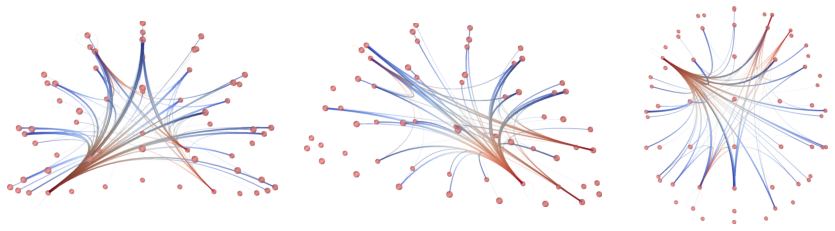

Channel types::	eeg: 61
attention weights for class "eyes-closed"


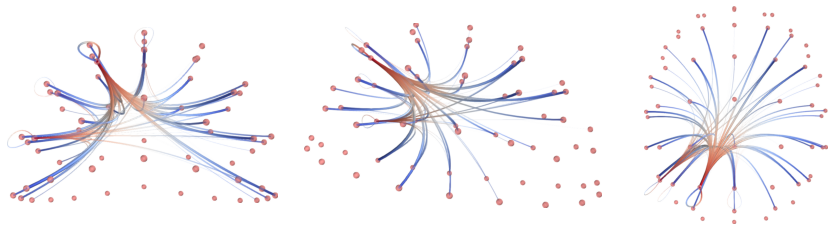

In [27]:
def trim_white(img):
    mask = (img == 1).all(axis=2)
    xs = np.where(~mask.all(axis=0))[0]
    ys = np.where(~mask.all(axis=1))[0]
    return img[ys[0]:ys[-1],xs[0]:xs[-1]]

def combined_view(condition, model_mask=None, result_dir="../figures/"):
    fig = plot_3d(condition=condition, model_mask=model_mask)
    fig.scene.y_minus_view()
    mlab.roll(0, figure=fig)
    mlab.savefig("/tmp/front.png", magnification=2)
    fig.scene.x_plus_view()
    mlab.savefig("/tmp/side.png", magnification=2)
    fig.scene.z_plus_view()
    mlab.savefig("/tmp/top.png", magnification=2)
    mlab.close()

    axes = plt.subplots(1, 3, figsize=(15, 4), gridspec_kw=dict(width_ratios=[1, 1.1, 0.8]))[1]
    axes[0].imshow(trim_white(plt.imread("/tmp/front.png")))
    axes[0].axis("off")
    axes[1].imshow(trim_white(plt.imread("/tmp/side.png")))
    axes[1].axis("off")
    axes[2].imshow(trim_white(plt.imread("/tmp/top.png")))
    axes[2].axis("off")
    plt.subplots_adjust(wspace=0.1)
    plt.savefig(join(result_dir, f"{condition_mapping[condition].replace(' ', '_')}-3d.pdf"),
                dpi=300, bbox_inches="tight")
    plt.show()

print(model_name_mapping_comb, end="\n\n")
for condition in range(len(condition_mapping)):
    combined_view(condition=condition)


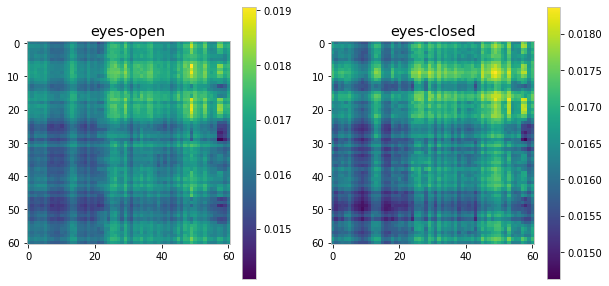

In [97]:
plt.figure(figsize=(10, 5))
attns = []
for i in range(len(condition_mapping)):
    a = attn[condition_masks[i]][:,1:,1:]
    
    # TODO: check if the reshape is correct
    a = a.reshape(-1, hparams.num_tokens, num_channels, num_channels, hparams.num_tokens)
    a = a.mean(dim=(0, 1, 4))
    
    # TODO: is this double normalization justified?
    a /= a.sum(dim=0)
    a /= a.sum(dim=1)
    
    attns.append(a)
    
    plt.subplot(1, len(condition_mapping), i + 1)
    plt.title(condition_mapping[i])
    plt.imshow(a)
    plt.colorbar()
    plt.grid(False)

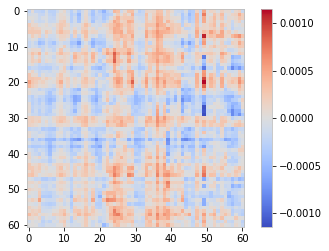

In [100]:
diff = attns[0] - attns[1]
plt.imshow(diff, vmin=-diff.abs().max(), vmax=diff.abs().max(), cmap="coolwarm")
plt.colorbar()
plt.grid(False)